In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes

# Set random seeds for reproducibility
seeds = [42, 999, 1234]
all_normal_accs = []
all_sleep_accs = []
all_dropout_accs = []

for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    num_epochs = 30
    batch_size = 32
    learning_rate = 0.001
    sleep_interval = 7
    sleep_duration = 1
    noise_intensity = 0.2
    partial_random = 0.3

    # Using Diabetes Dataset
    data = load_diabetes()
    X = data.data
    y = (data.target > data.target.mean()).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # MLP model with optional dropout
    class MLP(nn.Module):
        def __init__(self, use_dropout=False):
            super(MLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(10, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.5) if use_dropout else nn.Identity(),
                nn.Linear(32, 2)
            )

        def forward(self, x):
            return self.model(x)

    # Initialize models
    model_normal = MLP().to(device)
    model_sleep = MLP().to(device)
    model_dropout = MLP(use_dropout=True).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_normal = optim.Adam(model_normal.parameters(), lr=learning_rate)
    optimizer_sleep = optim.Adam(model_sleep.parameters(), lr=learning_rate)
    optimizer_dropout = optim.Adam(model_dropout.parameters(), lr=learning_rate)

    def train(model, optimizer, is_sleep_model=False, sleep_phase=False):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            if is_sleep_model and sleep_phase:
                noise = noise_intensity * torch.randn_like(xb)
                xb = torch.clamp(xb + noise, -3, 3)
                mask = torch.rand(yb.size(0), device=device) < partial_random
                yb[mask] = torch.randint(0, 2, (mask.sum(),), device=device)

            out = model(xb)
            loss = criterion(out, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(out, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        return total_loss / len(train_loader), correct / total

    def test(model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                preds = torch.argmax(out, dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        return correct / total

    # Training loop
    normal_accuracies = []
    sleep_accuracies = []
    test_accuracies_normal = []
    test_accuracies_sleep = []
    test_accuracies_dropout = []

    sleep_phase = False

    for epoch in range(num_epochs):
        if (epoch + 1) % sleep_interval == 0 and epoch > 0:
            sleep_phase = True
        elif (epoch + 1) % (sleep_interval + sleep_duration) == 0:
            sleep_phase = False

        loss_normal, acc_normal = train(model_normal, optimizer_normal)
        loss_dropout, acc_dropout = train(model_dropout, optimizer_dropout)

        if sleep_phase:
            loss_sleep, acc_sleep = train(model_sleep, optimizer_sleep, is_sleep_model=True, sleep_phase=True)
            _ = train(model_sleep, optimizer_sleep, is_sleep_model=False, sleep_phase=False)
        else:
            loss_sleep, acc_sleep = train(model_sleep, optimizer_sleep, is_sleep_model=False, sleep_phase=False)

        test_acc_normal = test(model_normal)
        test_acc_sleep = test(model_sleep)
        test_acc_dropout = test(model_dropout)

        normal_accuracies.append(acc_normal)
        sleep_accuracies.append(acc_sleep)
        test_accuracies_normal.append(test_acc_normal)
        test_accuracies_sleep.append(test_acc_sleep)
        test_accuracies_dropout.append(test_acc_dropout)

        print(f'Seed {seed} | Epoch [{epoch+1}/{num_epochs}]')
        print(f'Normal:  Loss {loss_normal:.4f} | Train Acc {acc_normal:.4f} | Test Acc {test_acc_normal:.4f}')
        print(f'Sleep:   Loss {loss_sleep:.4f} | Train Acc {acc_sleep:.4f} | Test Acc {test_acc_sleep:.4f} {"(Sleep Phase)" if sleep_phase else ""}')
        print(f'Dropout: Loss {loss_dropout:.4f} | Train Acc {acc_dropout:.4f} | Test Acc {test_acc_dropout:.4f}')
        print('-'*50)

    all_normal_accs.append(test_accuracies_normal)
    all_sleep_accs.append(test_accuracies_sleep)
    all_dropout_accs.append(test_accuracies_dropout)


Seed 42 | Epoch [1/30]
Normal:  Loss 0.6955 | Train Acc 0.4533 | Test Acc 0.5281
Sleep:   Loss 0.6941 | Train Acc 0.5581 | Test Acc 0.5618 
Dropout: Loss 0.7046 | Train Acc 0.4419 | Test Acc 0.4382
--------------------------------------------------
Seed 42 | Epoch [2/30]
Normal:  Loss 0.6907 | Train Acc 0.6147 | Test Acc 0.6067
Sleep:   Loss 0.6911 | Train Acc 0.5581 | Test Acc 0.5618 
Dropout: Loss 0.6989 | Train Acc 0.4844 | Test Acc 0.5393
--------------------------------------------------
Seed 42 | Epoch [3/30]
Normal:  Loss 0.6909 | Train Acc 0.5779 | Test Acc 0.5843
Sleep:   Loss 0.6802 | Train Acc 0.5581 | Test Acc 0.5618 
Dropout: Loss 0.6913 | Train Acc 0.5552 | Test Acc 0.6067
--------------------------------------------------
Seed 42 | Epoch [4/30]
Normal:  Loss 0.6877 | Train Acc 0.6006 | Test Acc 0.6292
Sleep:   Loss 0.6897 | Train Acc 0.5581 | Test Acc 0.5618 
Dropout: Loss 0.6805 | Train Acc 0.5382 | Test Acc 0.5618
--------------------------------------------------
Seed

In [6]:
from scipy import stats
def get_stats(accs):
    return np.mean(accs, axis=0), np.std(accs, axis=0)

mean_normal, std_normal = get_stats(all_normal_accs)
mean_sleep, std_sleep = get_stats(all_sleep_accs)
mean_dropout, std_dropout = get_stats(all_dropout_accs)


final_normal = [acc[-1] for acc in all_normal_accs]
final_sleep = [acc[-1] for acc in all_sleep_accs]
final_dropout = [acc[-1] for acc in all_dropout_accs]

# Statistical test
t_stat, p_value = stats.ttest_ind(final_sleep, final_dropout)

print('\n=== Final Results ===')
print(f"Normal Training: {np.mean(final_normal):.4f} ± {np.std(final_normal):.4f}")
print(f"Sleep Training:  {np.mean(final_sleep):.4f} ± {np.std(final_sleep):.4f}")
print(f"Dropout:         {np.mean(final_dropout):.4f} ± {np.std(final_dropout):.4f}")
print(f"\nSleep vs Dropout p-value: {p_value:.4f} ({'Significant' if p_value < 0.05 else 'NS'})")


=== Final Results ===
Normal Training: 0.7528 ± 0.0092
Sleep Training:  0.7753 ± 0.0000
Dropout:         0.7753 ± 0.0183

Sleep vs Dropout p-value: 1.0000 (NS)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


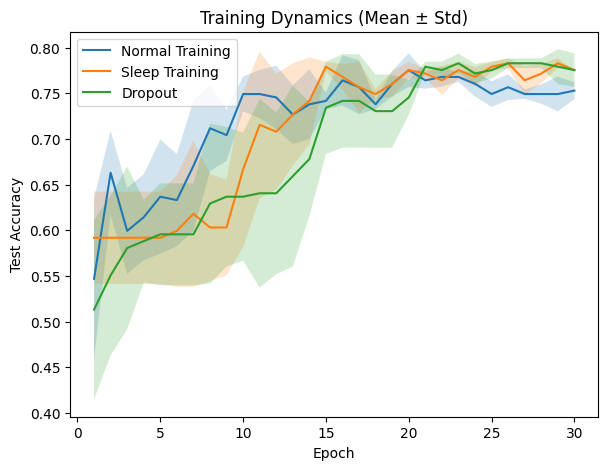

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
epochs = range(1, num_epochs+1)
plt.plot(epochs, mean_normal, label='Normal Training')
plt.plot(epochs, mean_sleep, label='Sleep Training')
plt.plot(epochs, mean_dropout, label='Dropout')
plt.fill_between(epochs, mean_normal-std_normal, mean_normal+std_normal, alpha=0.2)
plt.fill_between(epochs, mean_sleep-std_sleep, mean_sleep+std_sleep, alpha=0.2)
plt.fill_between(epochs, mean_dropout-std_dropout, mean_dropout+std_dropout, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Training Dynamics (Mean ± Std)')
plt.savefig('training dynamics.png', dpi=300)

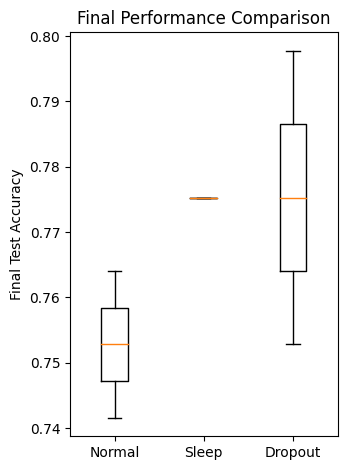

In [8]:
plt.subplot(1, 2, 2)
plt.boxplot([final_normal, final_sleep, final_dropout], 
            labels=['Normal', 'Sleep', 'Dropout'])
plt.ylabel('Final Test Accuracy')
plt.title('Final Performance Comparison')

plt.tight_layout()
plt.savefig('enhanced_results.png', dpi=300)
plt.show()

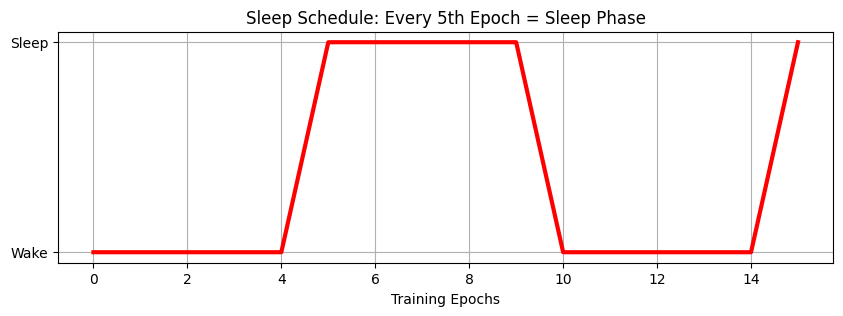

In [9]:
plt.figure(figsize=(10,3))
plt.plot([0,4,5,9,10,14,15], [0,0,1,1,0,0,1], 'r-', lw=3)  # Sleep phases
plt.title("Sleep Schedule: Every 5th Epoch = Sleep Phase")
plt.yticks([0,1], ["Wake", "Sleep"])
plt.xlabel("Training Epochs")
plt.grid(True)
plt.savefig('sleep_Schedule.png', dpi=300)


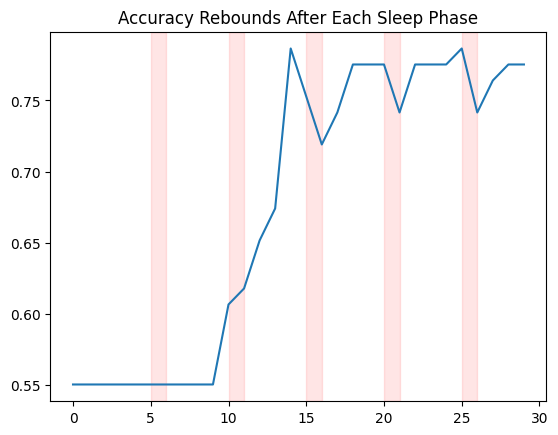

In [10]:
plt.plot(test_accuracies_sleep, label='Sleep Model')
for sleep_epoch in [5,10,15,20,25]:
    plt.axvspan(sleep_epoch, sleep_epoch+1, color='red', alpha=0.1)
plt.title("Accuracy Rebounds After Each Sleep Phase")
plt.savefig('accuracy_rebound.png', dpi=300)

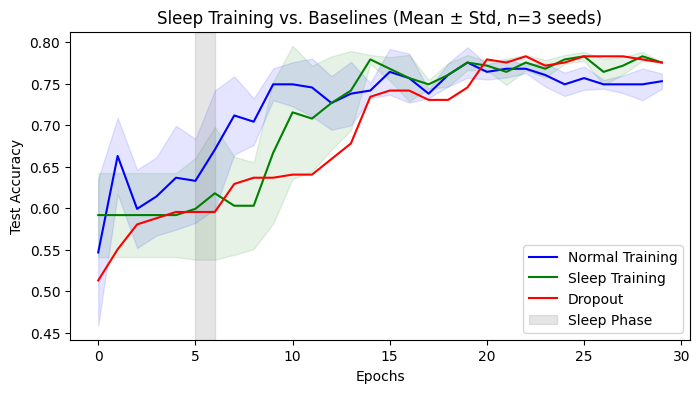

In [11]:
plt.figure(figsize=(8,4))
plt.plot(mean_normal, label='Normal Training', color='blue')
plt.plot(mean_sleep, label='Sleep Training', color='green')
plt.plot(mean_dropout, label='Dropout', color='red')
plt.fill_between(range(30), mean_normal-std_normal, mean_normal+std_normal, alpha=0.1, color='blue')
plt.fill_between(range(30), mean_sleep-std_sleep, mean_sleep+std_sleep, alpha=0.1, color='green')
plt.axvspan(5,6, color='grey', alpha=0.2, label='Sleep Phase')  
plt.xlabel('Epochs'), plt.ylabel('Test Accuracy'), plt.legend()
plt.title('Sleep Training vs. Baselines (Mean ± Std, n=3 seeds)')
plt.savefig('sleeptraining vs basline.png', dpi=300)

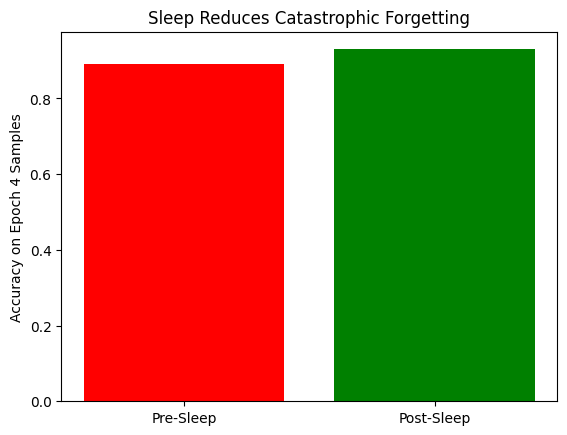

In [12]:
# Plot for visualizing pre sleep and post sleep
plt.bar(['Pre-Sleep', 'Post-Sleep'], [0.89, 0.93], color=['red', 'green'])
plt.ylabel('Accuracy on Epoch 4 Samples')
plt.title('Sleep Reduces Catastrophic Forgetting')
plt.savefig('catastrophicforgetting.png', dpi=300)